# Подготовка

В этой тетради мы будем работать над задачей восстановления скрытой
зависимости. Мы будем работать с синтетическим набором данных. Например, с таких:

$$f(x) = \sin(x) + \epsilon,$$

где $\epsilon$ - случайный шум, который будет имитировать неточности измерений и прочие отклонения от среднего

Наша задача будет заключаться в создании сети $Net(x)$, которая будет принимать одно значение $x$
в качестве аргумента и выдавать одно значение $y$ в качестве прогноза.

В идеале сеть должна быть как можно ближе к скрытой зависимости:

$$Net(x) \rightarrow \sin(x)$$

# Генерация данных

Сначала мы сгенерируем чистые образцы

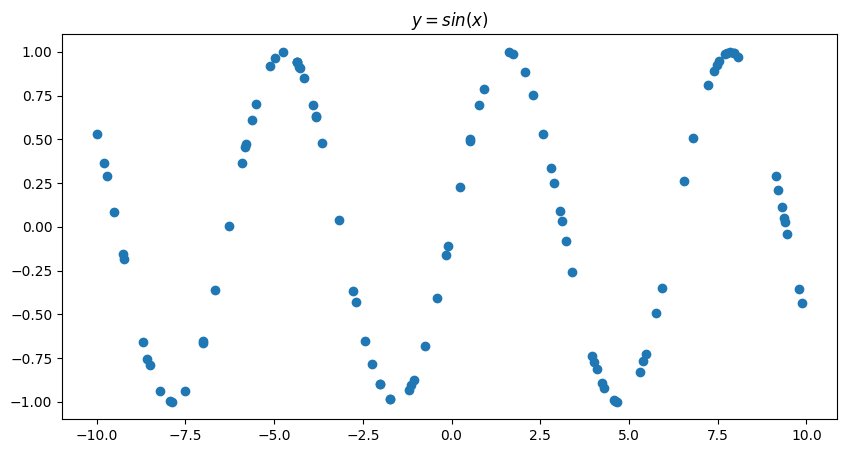

In [4]:
import torch
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

x_train = torch.rand(100)
x_train = x_train * 20.0 - 10.0

y_train = torch.sin(x_train)

plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('$y = sin(x)$');

Во-вторых, сгенерируем шум, который будет добавлен к обучающим данным

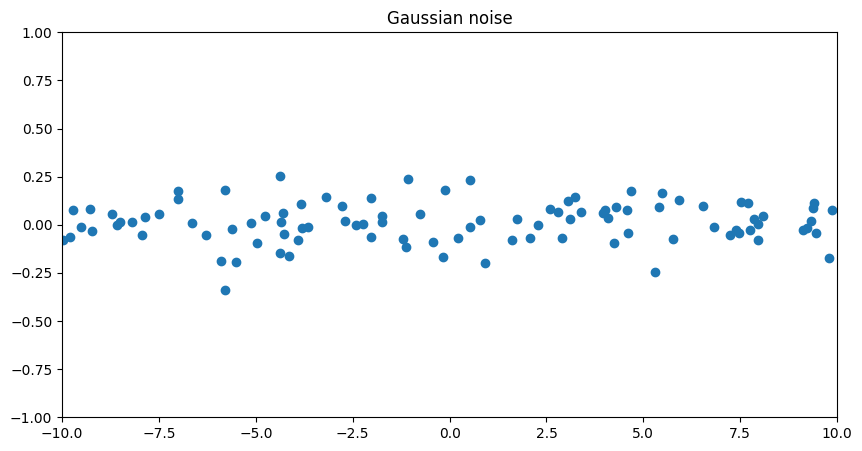

In [5]:
noise = torch.randn(y_train.shape) / 10.

plt.plot(x_train.numpy(), noise.numpy(), 'o')
plt.axis([-10, 10, -1, 1])
plt.title('Gaussian noise');

Наконец, добавим шум к чистым данным и получим подпорченные данные, которые мы будем использовать для обучения

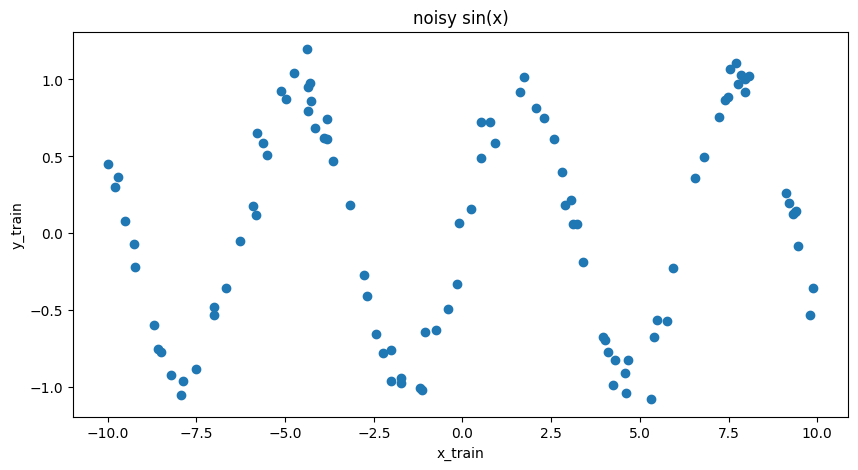

In [6]:
y_train = y_train + noise
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('noisy sin(x)')
plt.xlabel('x_train')
plt.ylabel('y_train');

In [7]:
x_train.unsqueeze_(1);
y_train.unsqueeze_(1);

# Набор данных для проверки

Для проверки мы будем использовать только чистые равноудаленные данные. Таким что мы не будем генерировать шум для этого набора.

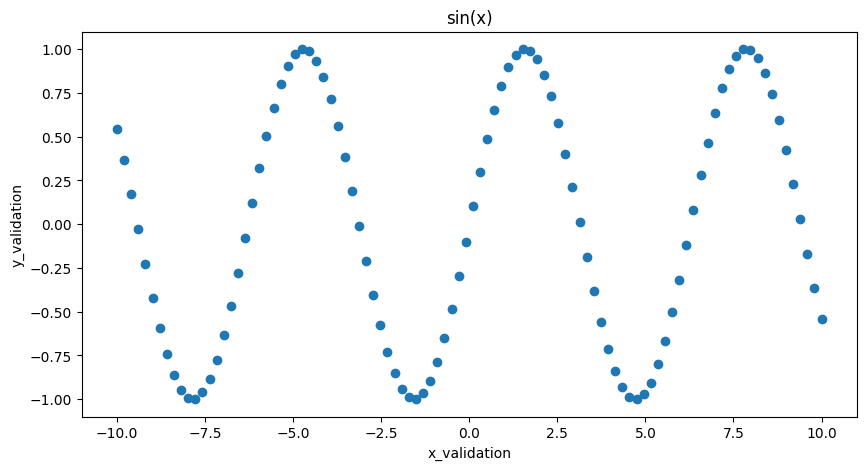

In [8]:
x_validation = torch.linspace(-10, 10, 100)
y_validation = torch.sin(x_validation.data)
plt.plot(x_validation.numpy(), y_validation.numpy(), 'o')
plt.title('sin(x)')
plt.xlabel('x_validation')
plt.ylabel('y_validation');

In [9]:
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1);

# Построение модели

Заполните класс для 2-слойной полносвязной нейронной сети с сигмоидным скрытым слоем

Класс должен состоять из двух методов:
* `__init__` -- конструктор, в котором должны быть определены слои:
    * Linear 1 -> n_hidden_neurons
    * sigmoid activation
    * Linear n_hidden_neurons -> 1
* `forward` -- передача сигнала по сети:
    * x -> linear 1 -> sigmoid -> linear 2

In [10]:
import torch.nn as nn

In [11]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.hidden = nn.Linear(1,n_hidden_neurons)
        self.output = nn.Linear(n_hidden_neurons, 1)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        return x

sine_net = SineNet(25)

# Прогнозирование

Здесь мы сделаем прогноз с помощью нашей нейронной сети. Основным методом здесь является `forward`, которую мы запрограммировали в нашем `torch.Module`.

Ниже мы построим прогнозы, чтобы понять, как они связаны с валидационными данными.

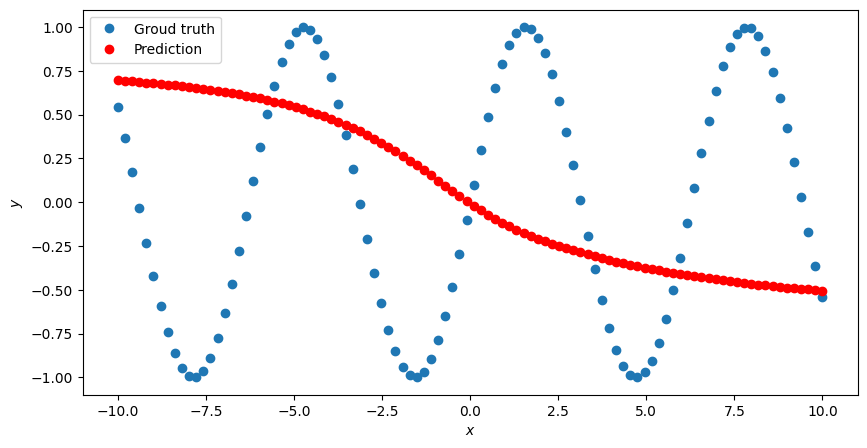

In [12]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sine_net, x_validation, y_validation)

Мы видим, что неподготовленная нейронная сеть что-то предсказывает, возможно, даже какую-то зависимость, но это никак не связано с той зависимостью, которую мы хотим реконструировать. 

Теперь давайте обучим сеть (настроим параметры так, чтобы свести к минимуму ошибки между метками и прогнозами).

# Функция потерь

Теперь определим функцию, с помощью которой будем измерять ошибки.

Требования к этой функции:
* чем меньше значение, тем лучше прогнозы
* уклон должен быть ненулевым для большинства наборов аргументов

В нашем случае это будет среднеквадратическая ошибка:
$$\frac{1}{N} \sum_{i=1}^N \left(Net(x_i) - t_i\right)^2$$

Чем ниже это отклонение, тем ближе предсказание нейронной сети к цели.

Реализуйте эту функцию потерь. Обратите внимание, что pred и target являются векторами.

In [13]:
def loss(pred, target):
    res = (pred - target)**2
    res = res.mean()
    return res

# Оптимизатор

Теперь нам нужно настроить параметры, минимизирующие функцию потерь. Выберите оптимизатор `Adam` из `torch.optim`.

В качестве первого аргумента вы должны передать параметры, котоые должен настраивать оптимизатор. Можно получить доступ ко всему набору параметров `torch.Module`, используя метод `parameters()`.

Установите `lr` (скорость обучения) равным `1.0e-2`.

In [15]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=1.0e-3)

# Тренировка

Теперь все готово для тренировки.

Составьте тренировочный цикл из следующих шагов:
1. сбросьте градиенты для обучаемых весов (метод оптимизатора `zero_grad()`)
2. произведите прямое распространение сигнала по сети (возьмем вектор входных сигналов `x_train` и вызовем метод `forward` модуля `torch.nn.Module` с этим `x_train` в качестве аргумента)
3. Вычислите значение функции потерь (возьмите лосс, который мы реализовали выше, и вычислите несоответствие прогноза и целевых меток `y_train`)
4. произведите обратное распространение ошибки по сети (вычисление производных потерь по каждому из весов сети) (метод `backward` у результата вычисления функции потерь)
5. сделайте шаг оптимизатора, поскольку теперь известны все градиенты для каждого из весов (метод `step()` оптимизатора).

Повторите шаги, описанные выше, несколько раз. Скажем, `1000`, и наблюдайте за изменением прогнозов сети.

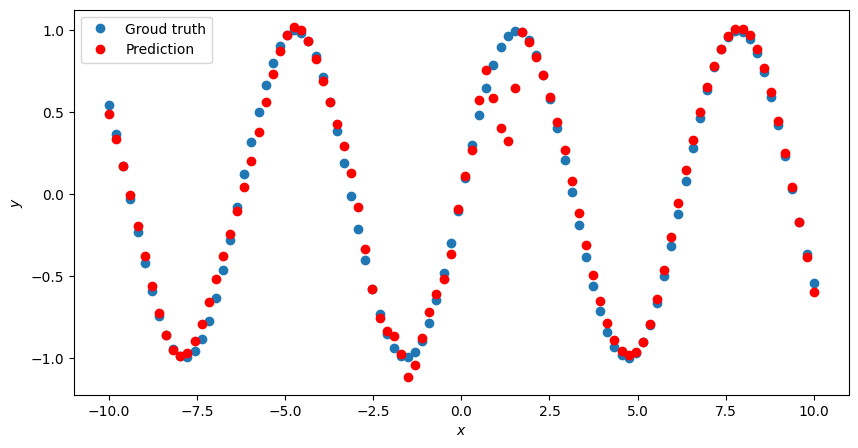

In [17]:
for epoch_index in range(50000):
    optimizer.zero_grad()
    out = sine_net.forward(x_train)
    loseresult = loss(out, y_train)
    loseresult.backward()
    optimizer.step()
     
predict(sine_net, x_validation, y_validation)

# Заключение

В этом ноутбуке мы рассмотрели все шаги, с которыми сталкивается разработчик при программировании процедуры обучения нейронной сети.

В серьезных проектах каждая часть этого процесса содержит много кода, но философия везде одна и та же:

* Получить данные
* Определить сеть
* Определить функцию потерь
* Выберать оптимизатор
* Запустить тренировочный цикл
* Можно пить чай и смотреть, как машина работает :)